# Baseline xG (Goal vs Non-Goal) — Skeleton

We'll load ../data/xgoal-db.sqlite if present, build simple geometry/context features, train a calibrated Logistic Regression, and produce basic metrics + explanations. Non-penalty, non-own-goal only. Everything is guarded so the notebook runs even when the DB is missing.


In [1]:
# Core
import os, sqlite3, math, json
from pathlib import Path

# Data
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.impute import SimpleImputer

# Plots
import matplotlib.pyplot as plt

# Repro
SEED = 42
np.random.seed(SEED)

# ---- Config ----
DB_PATH = Path("../data/xgoal-db.sqlite")   # <— YOUR DB path
USE_MATERIALIZED_WIDE = True                # if table shots_wide exists, use it
PRINT_ROWS = 5


In [2]:
WIDE_CTE_SQL = """
WITH ff AS (
    SELECT
        shot_id,
        COUNT(*)                                                AS ff_count,
        SUM(CASE WHEN teammate = 1 THEN 1 ELSE 0 END)          AS ff_teammates,
        SUM(CASE WHEN teammate = 0 THEN 1 ELSE 0 END)          AS ff_opponents,
        SUM(CASE WHEN keeper   = 1 THEN 1 ELSE 0 END)          AS ff_keeper_count,
        AVG(CASE WHEN keeper   = 1 THEN x END)                 AS ff_keeper_x,
        AVG(CASE WHEN keeper   = 1 THEN y END)                 AS ff_keeper_y
    FROM freeze_frames
    GROUP BY shot_id
)
SELECT
    s.*,
    e.under_pressure       AS event_under_pressure,
    e.counterpress         AS event_counterpress,
    e.duration             AS event_duration,
    ff.ff_count,
    ff.ff_teammates,
    ff.ff_opponents,
    ff.ff_keeper_count,
    ff.ff_keeper_x,
    ff.ff_keeper_y
FROM shots s
LEFT JOIN events e ON e.event_id = s.shot_id
LEFT JOIN ff     ON ff.shot_id   = s.shot_id;
"""

def load_wide_df(db_path: Path, use_materialized: bool = True) -> pd.DataFrame | None:
    if not db_path.exists():
        print(f"[info] DB not found at {db_path.resolve()}. Proceeding with skeleton only.")
        return None
    with sqlite3.connect(db_path) as conn:
        tables = set(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)["name"])
        if "shots_wide" in tables and use_materialized:
            df = pd.read_sql("SELECT * FROM shots_wide;", conn)
        else:
            df = pd.read_sql(WIDE_CTE_SQL, conn)
    if not df.empty and not df["shot_id"].is_unique:
        raise ValueError("shot_id must be unique (one row per shot)")
    return df

df = load_wide_df(DB_PATH, USE_MATERIALIZED_WIDE)
print("[info] df is", None if df is None else df.shape)
if df is not None:
    display(df.head(PRINT_ROWS))


[info] df is (88023, 50)


,shot_id,match_id,team_id,opponent_team_id,player_id,possession,possession_team_id,period,minute,second,...,freeze_frame_count,event_under_pressure,event_counterpress,event_duration,ff_count,ff_teammates,ff_opponents,ff_keeper_count,ff_keeper_x,ff_keeper_y
0,6a0741a9-8324-48ad-9647-04a342bd9e39,0,241,239,7149,2,241,1,0,15.0,...,10,NaN,None,0.112927,10.0,2.0,8.0,1.0,118.9,41.8
1,ccb673c1-37ca-48c0-9249-927469dccf9b,0,220,217,3496,3,220,1,0,20.0,...,11,NaN,None,0.403501,11.0,4.0,7.0,1.0,118.8,39.7
2,44befb97-6618-48a9-8607-8da6c605f339,0,220,217,19677,3,220,1,0,22.0,...,8,NaN,None,0.684151,8.0,2.0,6.0,1.0,119.2,41.3
3,5f0f0db7-2548-4ca9-9eb6-71b7b96448f1,0,178,872,20359,3,178,1,0,44.0,...,17,1.0,None,0.854850,17.0,7.0,10.0,1.0,118.5,36.0
4,f6cb589b-95a2-49bb-9c95-2982e02ff65b,0,160,146,10616,3,160,1,0,46.0,...,13,NaN,None,1.010053,13.0,4.0,9.0,1.0,119.0,39.8


In [3]:
if df is None or df.empty:
    print("[warn] No data loaded. Creating a tiny mock frame so the notebook runs end-to-end.")
    df = pd.DataFrame({
        "shot_id": ["a","b","c"],
        "outcome": ["Goal","Saved","Miss"],
        "is_penalty": [False, False, False],
        "is_own_goal": [False, False, False],
        "start_x": [100.0, 90.0, 80.0],
        "start_y": [40.0, 30.0, 50.0],
        "body_part": ["Right Foot","Head","Left Foot"],
        "is_set_piece": [False, False, True],
        "is_corner": [False, False, False],
        "is_free_kick": [False, False, True],
        "first_time": [True, False, False],
        "under_pressure": [False, True, False],
        "ff_opponents": [1.0, 3.0, 0.0],
        "ff_keeper_x": [118.0, 119.0, 117.5],
        "ff_keeper_y": [40.0, 41.0, 39.5],
        "match_id": [1,1,1],
    })

df0 = df.copy()
mask_valid = (~df0["is_penalty"].astype(bool)) & (~df0["is_own_goal"].astype(bool))
data = df0.loc[mask_valid].copy()

y = (data["outcome"] == "Goal").astype(int)
LEAKY = [c for c in ["end_x","end_y","end_z"] if c in data.columns]
data = data.drop(columns=LEAKY, errors="ignore")
print("rows:", len(data), "goals:", int(y.sum()), "base rate:", float(y.mean()))


rows: 86662 goals: 8792 base rate: 0.10145161662551061


In [4]:
SB_LEN, SB_WID = 120.0, 80.0
GOAL_YC_SB = 40.0
GOAL_HALF_W_SB = (7.32/2) * (SB_WID / 68.0)  # ~3.66m scaled to SB units

def distance_sb(x, y):
    dx = SB_LEN - x
    dy = GOAL_YC_SB - y
    return np.hypot(dx, dy)

def opening_angle_deg_sb(x, y):
    left  = np.array([SB_LEN, GOAL_YC_SB - GOAL_HALF_W_SB])
    right = np.array([SB_LEN, GOAL_YC_SB + GOAL_HALF_W_SB])
    p = np.column_stack([x, y])
    v1 = left  - p
    v2 = right - p
    dot = (v1 * v2).sum(axis=1)
    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)
    cosang = np.clip(dot/(n1*n2), -1, 1)
    return np.degrees(np.arccos(cosang))


In [5]:
X = pd.DataFrame(index=data.index)
X["dist_sb"] = distance_sb(data["start_x"].to_numpy(), data["start_y"].to_numpy())
X["angle_deg_sb"] = opening_angle_deg_sb(data["start_x"].to_numpy(), data["start_y"].to_numpy())

def to_num(s):
    if pd.api.types.is_bool_dtype(s):
        return s.fillna(False).astype(int)
    return pd.to_numeric(s, errors="coerce")

for col in ["is_set_piece","is_corner","is_free_kick","first_time","under_pressure"]:
    if col in data.columns:
        X[col] = to_num(data[col].astype("boolean"))
    else:
        X[col] = 0

X["is_header"] = (data.get("body_part", "") == "Head").astype(int) if "body_part" in data.columns else 0

if {"ff_keeper_x","ff_keeper_y"}.issubset(data.columns):
    X["gk_depth_sb"] = np.maximum(0.0, SB_LEN - data["ff_keeper_x"])
    X["gk_offset_sb"] = data["ff_keeper_y"] - GOAL_YC_SB
else:
    X["gk_depth_sb"] = 0.0
    X["gk_offset_sb"] = 0.0

if "ff_opponents" in data.columns:
    X["ff_opponents"] = pd.to_numeric(data["ff_opponents"], errors="coerce")
else:
    X["ff_opponents"] = 0.0

X = X.apply(pd.to_numeric, errors="coerce")
display(X.describe().T.head(10))


,count,mean,std,min,25%,50%,75%,max
dist_sb,86662.0,19.294575,8.768259,0.4,12.229881,18.638938,25.603515,92.800862
angle_deg_sb,86662.0,27.113283,16.822261,0.0,16.128874,21.084074,33.008305,180.000000
is_set_piece,86662.0,0.049156,0.216196,0.0,0.000000,0.000000,0.000000,1.000000
is_corner,86662.0,0.000323,0.017972,0.0,0.000000,0.000000,0.000000,1.000000
is_free_kick,86662.0,0.048822,0.215497,0.0,0.000000,0.000000,0.000000,1.000000
first_time,86662.0,0.307517,0.461468,0.0,0.000000,0.000000,1.000000,1.000000
under_pressure,86662.0,0.241063,0.427731,0.0,0.000000,0.000000,0.000000,1.000000
is_header,86662.0,0.161132,0.367655,0.0,0.000000,0.000000,0.000000,1.000000
gk_depth_sb,86607.0,2.475010,2.290509,0.0,1.200000,1.900000,3.000000,118.000000
gk_offset_sb,86607.0,0.052205,2.605747,-25.9,-1.500000,0.000000,1.500000,35.100000


In [6]:
def grouped_split(X, y, groups):
    idx = np.arange(len(X))
    if len(idx) == 0:
        return idx, idx

    if groups is None:
        rng = np.random.default_rng(SEED)
        rng.shuffle(idx)
        cut = int(0.8 * len(idx))
        return idx[:cut], idx[cut:]

    groups = pd.Series(groups).reset_index(drop=True)
    unknown_mask = groups.isna() | (groups == 0)
    known_idx = idx[~unknown_mask.to_numpy()]
    unknown_idx = idx[unknown_mask.to_numpy()]

    if len(known_idx) == 0:
        print("[warn] All match_ids are missing/zero; reserving them for test only.")
        return np.array([], dtype=int), unknown_idx

    known_groups = groups.loc[~unknown_mask]
    if known_groups.nunique() < 2 or len(known_idx) < 5:
        rng = np.random.default_rng(SEED)
        rng.shuffle(known_idx)
        cut = int(0.8 * len(known_idx))
        tr_known = known_idx[:cut]
        te_known = known_idx[cut:]
    else:
        n_splits = min(5, int(known_groups.nunique()))
        gkf = GroupKFold(n_splits=n_splits)
        group_values = known_groups.to_numpy()
        tr_loc, te_loc = next(gkf.split(X.iloc[known_idx], y.iloc[known_idx], group_values))
        tr_known = known_idx[tr_loc]
        te_known = known_idx[te_loc]

    test_idx = np.sort(np.concatenate([te_known, unknown_idx]))
    train_mask = np.ones(len(idx), dtype=bool)
    train_mask[test_idx] = False
    train_idx = idx[train_mask]
    return train_idx.astype(int), test_idx.astype(int)

groups = data["match_id"] if "match_id" in data.columns else None
train_idx, test_idx = grouped_split(X, y, groups)

X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

if groups is not None and len(train_idx) > 0 and (pd.Series(groups).iloc[train_idx] == 0).any():
    raise ValueError("match_id=0 should not appear in the training split")

print(X_tr.shape, X_te.shape, float(y_tr.mean()), float(y_te.mean()))


(67443, 11) (19219, 11) 0.10315377429829634 0.09547843280087413


In [7]:
def safe_metrics(y_true, p):
    if len(np.unique(y_true)) < 2:
        return {"auc": np.nan, "logloss": np.nan, "brier": np.nan}
    return {
        "auc": float(roc_auc_score(y_true, p)),
        "logloss": float(log_loss(y_true, p)),
        "brier": float(brier_score_loss(y_true, p))
    }

cal = None
p_raw = None
p_cal = None

if len(X_tr) == 0 or len(np.unique(y_tr)) < 2:
    print("[warn] Not enough training data to fit the model.")
else:
    base = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(max_iter=1000, solver="lbfgs", C=1.0)
    )
    base.fit(X_tr, y_tr)
    p_raw = base.predict_proba(X_te)[:, 1] if len(X_te) else np.array([])
    print("Uncalibrated:", safe_metrics(y_te, p_raw) if len(p_raw) else {"auc": np.nan, "logloss": np.nan, "brier": np.nan})

    cal = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
    cal.fit(X_tr, y_tr)
    p_cal = cal.predict_proba(X_te)[:, 1] if len(X_te) else np.array([])
    print("Calibrated:", safe_metrics(y_te, p_cal) if len(p_cal) else {"auc": np.nan, "logloss": np.nan, "brier": np.nan})


Uncalibrated: {'auc': 0.8058325423108224, 'logloss': 0.2545874341600894, 'brier': 0.07210427445895876}


/Users/denniskoehn/Library/Caches/pypoetry/virtualenvs/xgoal-tutor-gTwRsLp9-py3.11/lib/python3.11/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrated: {'auc': 0.8058325423108224, 'logloss': 0.2545879195184148, 'brier': 0.07210443545622629}


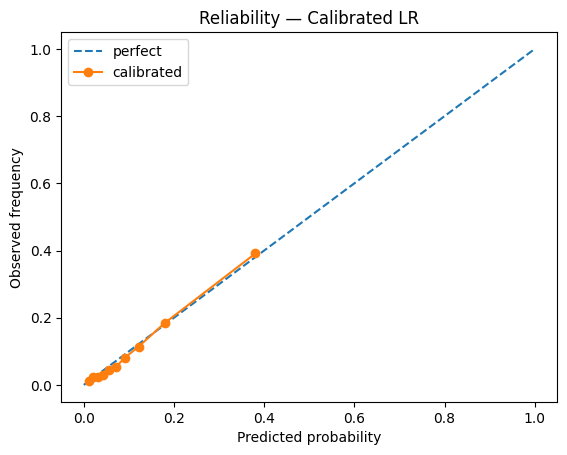

In [8]:
from sklearn.calibration import calibration_curve

if cal is not None and len(X_te) > 50 and len(np.unique(y_te)) == 2:
    prob_true, prob_pred = calibration_curve(y_te, p_cal, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot([0,1],[0,1], "--", label="perfect")
    plt.plot(prob_pred, prob_true, marker="o", label="calibrated")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Reliability — Calibrated LR")
    plt.legend(); plt.show()
else:
    print("[info] Skipping reliability plot (not enough test data or model not fit).")


In [9]:
def distance_phrase(d):
    return "close range" if d < 12 else "medium range" if d < 18 else "long range"

def angle_phrase(a):
    return "wide angle" if a > 25 else "moderate angle" if a > 10 else "tight angle"

def defenders_phrase(n):
    if n >= 3: return "crowded sightline"
    if n == 0: return "clear sight"
    return None

def gk_phrase(depth, offset):
    parts = []
    if depth >= 6: parts.append("deep GK")
    if abs(offset) >= 2.5: parts.append("GK off-center")
    return "; \n".join(parts) if parts else None

def explain_row(r: pd.Series, xg: float) -> str:
    bits = [f"{xg:.2f} xG — {distance_phrase(r['dist_sb'])}, {angle_phrase(r['angle_deg_sb'])}"]
    if r.get("first_time", 0) == 1: bits.append("first-time")
    if r.get("is_free_kick", 0) == 1: bits.append("direct free-kick")
    dp = defenders_phrase(int(r.get("ff_opponents", 0)))
    if dp: bits.append(dp)
    gp = gk_phrase(r.get("gk_depth_sb", 0.0), r.get("gk_offset_sb", 0.0))
    if gp: bits.append(gp)
    return ", \".join(bits) + "."

if cal is None:
    print("[info] Model not fit; skipping coefficient inspection.")
else:
    lr = cal.base_estimator.named_steps["logisticregression"]
    coef = lr.coef_[0]
    feat_names = X_tr.columns
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", ascending=False)
    display(coef_df.head(10)); display(coef_df.tail(10))

    # demo for a few test rows (guarded)
    n_demo = min(5, len(X_te))
    if n_demo > 0:
        demo = X_te.head(n_demo)
        px = cal.predict_proba(demo)[:,1]
        for r, p in zip(demo.itertuples(index=False), px):
            print(explain_row(pd.Series(r._asdict(), index=demo.columns), float(p)))
    else:
        print("[info] No test rows to demo explanations.")


SyntaxError: unterminated string literal (detected at line 26) (3618322056.py, line 26)

In [10]:
from pathlib import Path
import joblib, json

ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True, parents=True)

if cal is not None and len(X_tr) > 0:
    joblib.dump(cal, ART_DIR / "baseline_lr_calibrated.joblib")
    with open(ART_DIR / "feature_names.json", "w") as f:
        json.dump(list(X.columns), f, indent=2)
    with open(ART_DIR / "README.txt", "w") as f:
        f.write(
            "Baseline calibrated Logistic Regression for non-penalty shots.\n"
            "Inputs: features in feature_names.json\n"
            "Target: outcome == 'Goal'\n"
            "Calibration: Platt (sigmoid) on train fold\n"
        )
    print("Saved artifacts to:", ART_DIR.resolve())
else:
    print("[info] Skipping artifact save (model not fit).")


Saved artifacts to: /Users/denniskoehn/Documents/Git/src/xgoal_tutor/notebooks/artifacts


## Next steps

- Add defenders-in-cone & nearest-defender distance.
- Try isotonic calibration vs sigmoid.
- Add LightGBM (shallow) and compare Brier/LogLoss.
- Ensure GroupKFold across all folds for stable metrics.
- Plug model + explanation into FastAPI/Streamlit.
